In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product 
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from sklearn import metrics
from pandas import Series


In [2]:
data=pd.read_csv(r'file:///F:\Live%20Projects\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [3]:
data.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [4]:
data.shape

(4857377, 8)

In [5]:
#unix-time to
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
#Resampling to daily frequency
data.index=data.Timestamp
data=data.resample('D').mean()
#resampling to monthly frequency
data_month=data.resample('M').mean()
#resampling to annual frequency
data_year=data.resample('A-DEC').mean()
#resampling to quarterly frequency
data_Q=data.resample('Q-DEC').mean()

In [6]:
data.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819
2021-03-30,58347.805624,58371.955310,58323.956690,58349.357087,2.363999,138231.241926,58346.912268
2021-03-31,58767.750000,58778.180000,58755.970000,58778.180000,2.712831,159417.751000,58764.349363


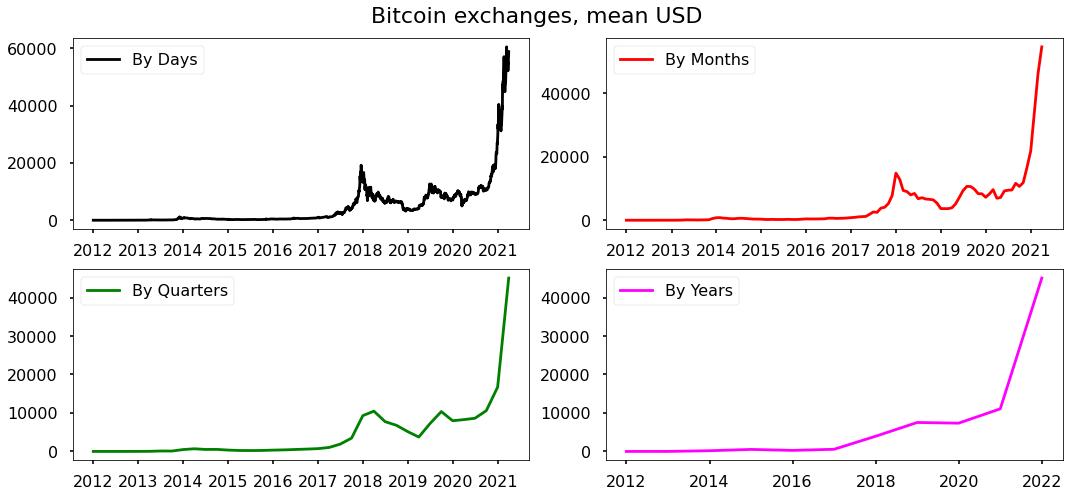

In [7]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(data.Weighted_Price, '-', label='By Days' , color = 'black')
plt.legend()

plt.subplot(222)
plt.plot(data_month.Weighted_Price, '-', label='By Months',  color = 'red')
plt.legend()

plt.subplot(223)
plt.plot(data_Q.Weighted_Price, '-', label='By Quarters',color = 'green')
plt.legend()

plt.subplot(224)
plt.plot(data_year.Weighted_Price, '-', label='By Years', color = 'magenta')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

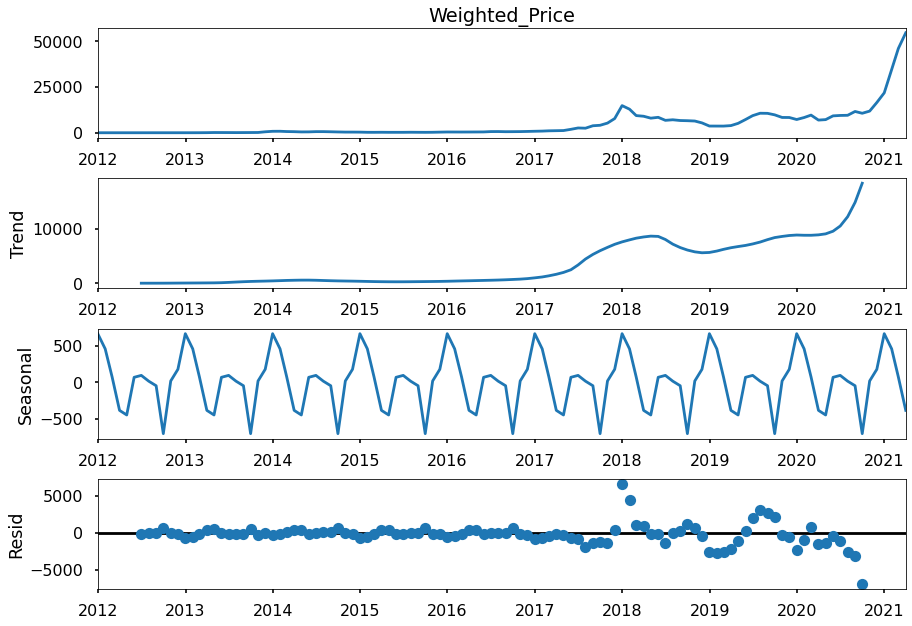

In [8]:
plt.figure(figsize=[10,5])
sm.tsa.seasonal_decompose(data_month["Weighted_Price"]).plot()
plt.show()

In [9]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [10]:
#the series is not stationary

In [11]:
#box cox transformation-non normal dependent variable to normal dist shape
data_month['Weighted_Price_box'],lmda=stats.boxcox(data_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [12]:
#Seasonal differentiation-seasonality component is deleted from each obs in python
data_month['prices_box_diff'] = data_month.Weighted_Price_box - data_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 360x360 with 0 Axes>

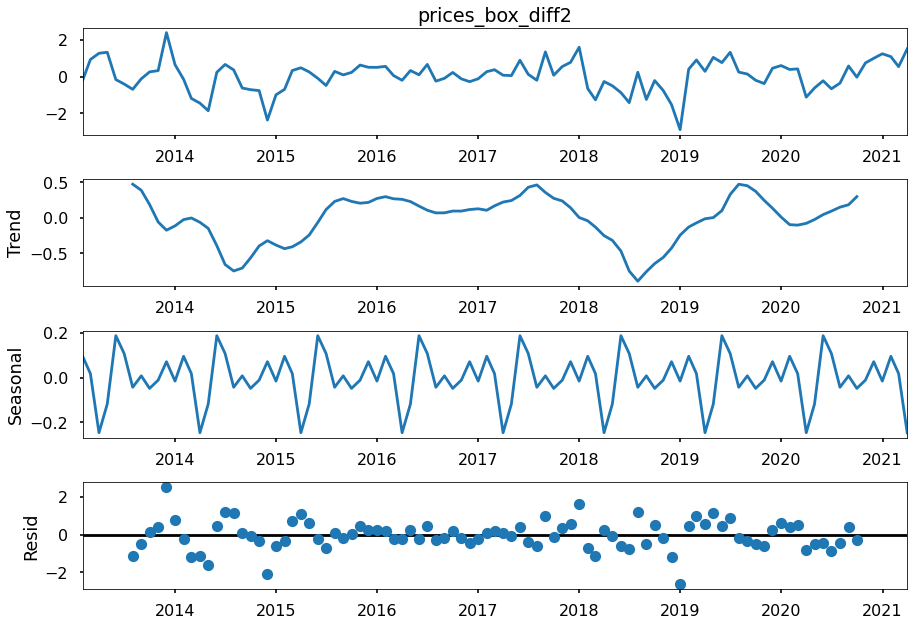

In [13]:
#Regular differentiation
data_month['prices_box_diff2'] = data_month.prices_box_diff - data_month.prices_box_diff.shift(1) 
                               
plt.figure(figsize=(5,5))
sm.tsa.seasonal_decompose(data_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % 
    sm.tsa.stattools.adfuller(data_month.prices_box_diff2[13:])[1])

plt.show()

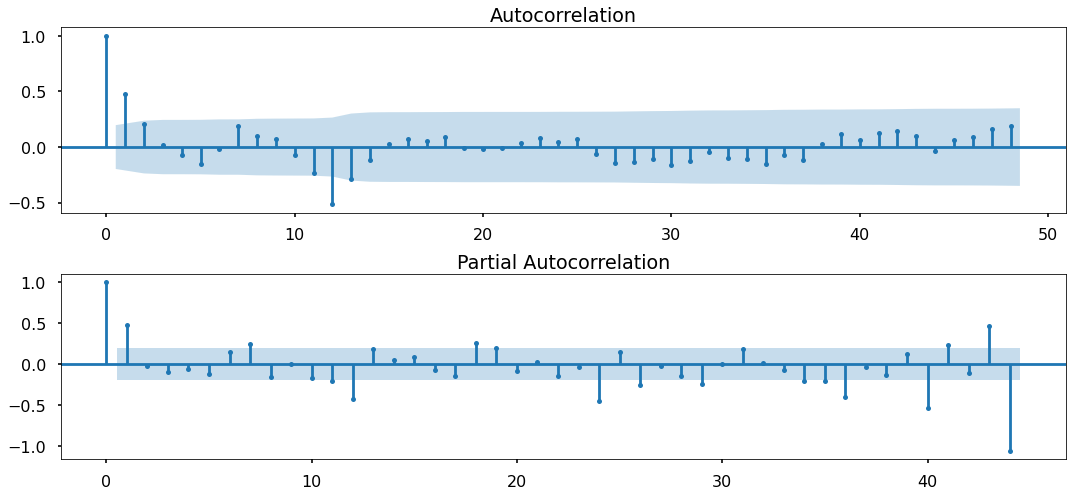

In [14]:
# Initial approximation of parameters using Autocorrelation and partial Autocorrelation plots
plt.figure(figsize=(15,7))
ax=plt.subplot(211)
sm.graphics.tsa.plot_acf(data_month.prices_box_diff2[13:].values.squeeze(),lags=48,ax=ax)
ax=plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_month.prices_box_diff2[13:].values.squeeze(),lags=44,ax=ax)
plt.tight_layout()
plt.show()

In [15]:
#Initial approximation of parameters
Qs=range(0,2)#order of parameters
qs=range(0,3)
Ps=range(0,3)
ps=range(0,3)
D=1
d=1
parameters=product(Ps,Qs,ps,qs)
parameters_list=list(parameters)
len(parameters_list)

54

In [16]:
#Model selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [17]:
#Best Models

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616110
20  (1, 0, 0, 2)  174.631541
22  (1, 0, 1, 1)  174.766384
28  (1, 1, 0, 1)  175.546792
37  (2, 0, 0, 1)  175.554257
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Fri, 23 Apr 2021   AIC                            173.616
Time:                                      08:51:01   BIC                            181.401
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

In [18]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Dickey–Fuller test: p=0.000000


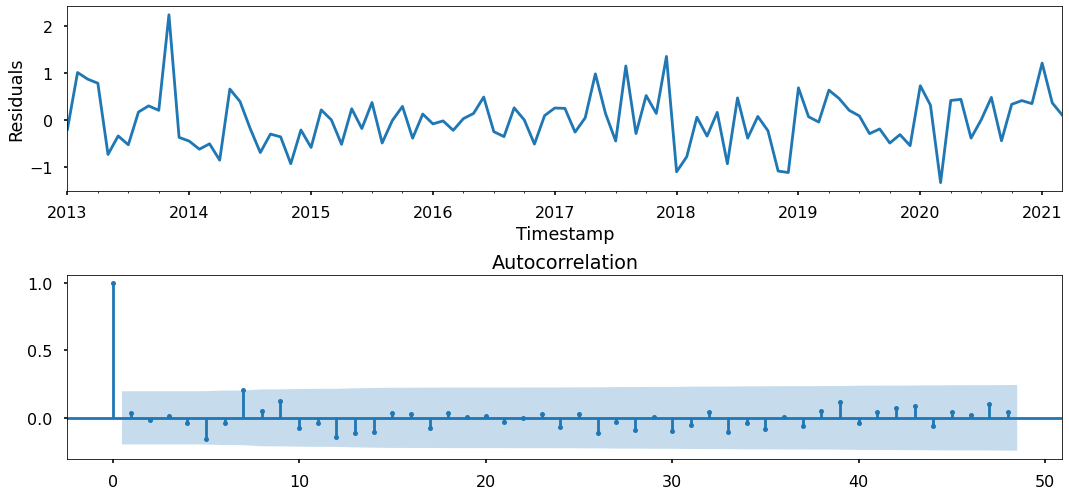

In [19]:
#Analysis of residuals
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(U'Residuals')
ax=plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(),lags=48,ax=ax)
plt.tight_layout()
plt.show()

In [35]:
#Prediction
#Inverse Box-Cox Transformation function
data_month['Weighted_Price_box'], param = stats.boxcox(data_month['Weighted_Price'])
print('Optimal lambda', param)


Optimal lambda 0.11462260714492067


In [36]:
invboxcox(data_month['Weighted_Price_box'], param)

Timestamp
2011-12-31        4.471603
2012-01-31        6.208550
2012-02-29        5.252527
2012-03-31        4.962021
2012-04-30        4.976547
                  ...     
2020-11-30    16530.401656
2020-12-31    21810.922846
2021-01-31    34551.684656
2021-02-28    46074.940877
2021-03-31    54638.339142
Freq: M, Name: Weighted_Price_box, Length: 112, dtype: float64

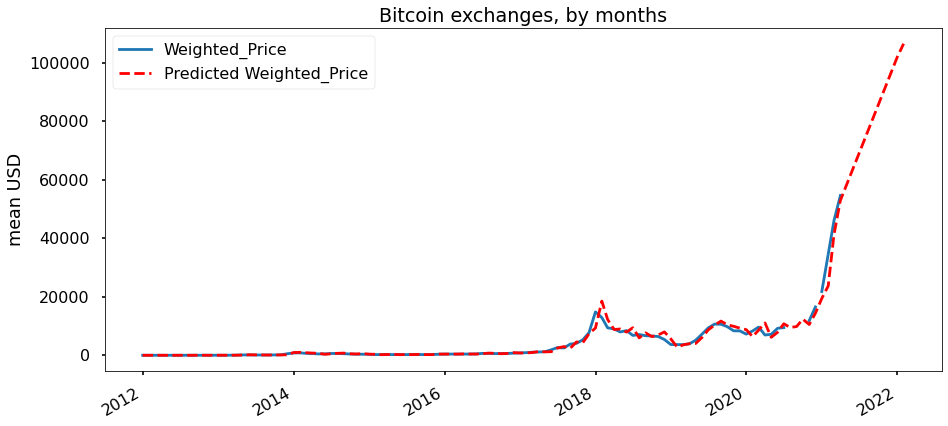

In [39]:
# Prediction
data_month2 = data_month[['Weighted_Price']]
date_list = [datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30), 
             datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2021, 12, 31), datetime(2022, 1, 31),
             datetime(2023, 1, 28),datetime(2023,1,28)]
future = pd.DataFrame(index=date_list, columns= data_month.columns)
data_month2 = pd.concat([data_month2, future])
data_month2['forecast'] = invboxcox(best_model.predict(start=0, end=180),param)
plt.figure(figsize=(15,7))
data_month2.Weighted_Price.plot()
data_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()